## Springboard Capstone : Data Wrangling and EDA

In [28]:
import glob, pylab
import pandas as pd
import os
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt

In [7]:
!pip install pydicom

In [8]:
import pydicom
import numpy as np
import seaborn as sns

In [10]:
# import all necessary keras modules
from keras import layers
from keras.applications import DenseNet121
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.callbacks import Callback, ModelCheckpoint
from keras.optimizers import Adam

Using TensorFlow backend.


In [14]:
data = pd.read_csv('stage_2_train.csv')

In [15]:
data.head()

,ID,Label
0,ID_12cadc6af_epidural,0
1,ID_12cadc6af_intraparenchymal,0
2,ID_12cadc6af_intraventricular,0
3,ID_12cadc6af_subarachnoid,0
4,ID_12cadc6af_subdural,0


In [16]:
data.shape

(4516842, 2)

In [18]:
tmp_table = data.copy()

In [20]:
tmp_table.Label.isnull().sum()

0

In [22]:
tmp_table.Label.value_counts()

0    4260600
1     256242
Name: Label, dtype: int64

In [26]:
train_images_dir = 'train/'
train_images = [i for i in listdir(train_images_dir) if isfile(join(train_images_dir, i))]
print(train_images[:5])

['ID_00005679d.dcm', 'ID_0000aee4b.dcm', 'ID_0000ca2f6.dcm', 'ID_0000f1657.dcm', 'ID_000a050f3.dcm']


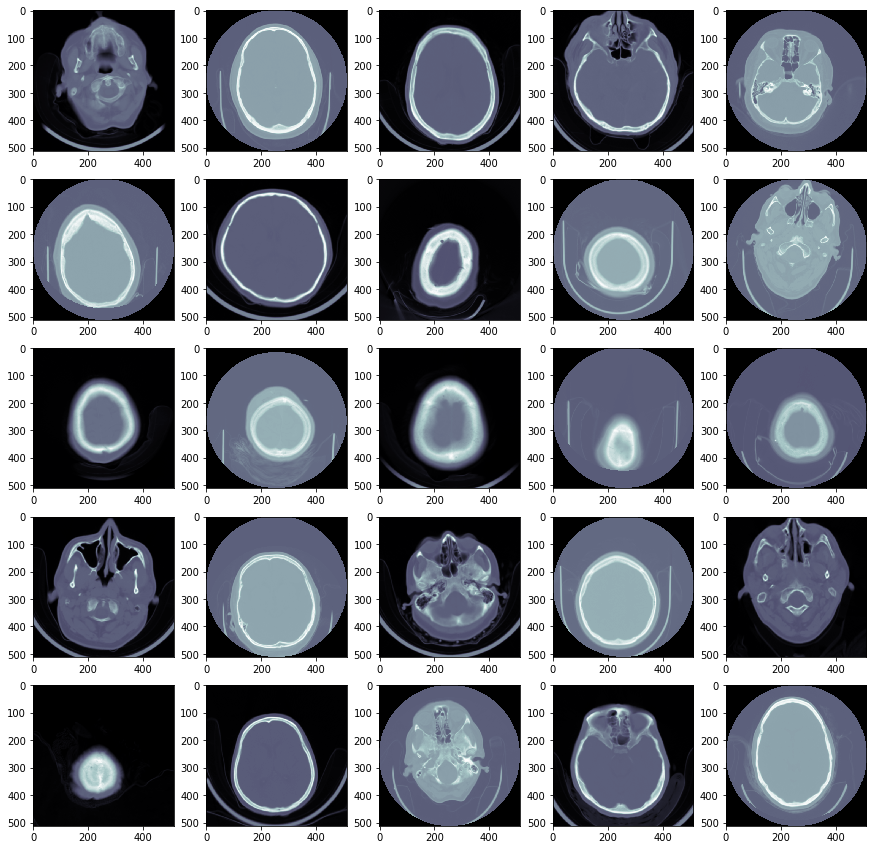

In [30]:
# Displaying the images
fig = plt.figure(figsize=(15, 15))
columns = 5
rows = 5

for i in range(1, columns*rows + 1):
    ds = pydicom.dcmread(train_images_dir + train_images[i])
    fig.add_subplot(rows, columns, i)
    plt.imshow(ds.pixel_array, cmap = plt.cm.bone)
    fig.add_subplot

In [31]:
# file type of the image
print(ds)

(0008, 0018) SOP Instance UID                    UI: ID_000c8cc79
(0008, 0060) Modality                            CS: 'CT'
(0010, 0020) Patient ID                          LO: 'ID_7a99f0ce'
(0020, 000d) Study Instance UID                  UI: ID_e48c740824
(0020, 000e) Series Instance UID                 UI: ID_8d4e79197b
(0020, 0010) Study ID                            SH: ''
(0020, 0032) Image Position (Patient)            DS: ['-125.000000', '-115.515236', '106.818634']
(0020, 0037) Image Orientation (Patient)         DS: ['1.000000', '0.000000', '0.000000', '0.000000', '0.994522', '-0.104528']
(0028, 0002) Samples per Pixel                   US: 1
(0028, 0004) Photometric Interpretation          CS: 'MONOCHROME2'
(0028, 0010) Rows                                US: 512
(0028, 0011) Columns                             US: 512
(0028, 0030) Pixel Spacing                       DS: ['0.488281', '0.488281']
(0028, 0100) Bits Allocated                      US: 16
(0028, 0101) Bits Stored

In [34]:
# image dimensions
img = ds.pixel_array
print(img.dtype)
print(img.shape)

int16
(512, 512)


In [52]:
# modifying our version of table

tmp_table['sub_type'] = tmp_table['ID'].str.split("_", n = 3, expand = True)[2]
tmp_table['patient_id'] = tmp_table['ID'].str.split("_", n = 3, expand = True)[1]

In [56]:
tmp_table.head()

,ID,Label,sub_type,patient_id
0,ID_12cadc6af_epidural,0,epidural,12cadc6af
1,ID_12cadc6af_intraparenchymal,0,intraparenchymal,12cadc6af
2,ID_12cadc6af_intraventricular,0,intraventricular,12cadc6af
3,ID_12cadc6af_subarachnoid,0,subarachnoid,12cadc6af
4,ID_12cadc6af_subdural,0,subdural,12cadc6af


In [40]:
# distribution for subtype

dist_subtype = tmp_table.groupby('sub_type').sum()
dist_subtype

,Label
sub_type,
any,107933
epidural,3145
intraparenchymal,36118
intraventricular,26205
subarachnoid,35675
subdural,47166


Text(0.5, 1.0, 'subtype distribution across the dataset')

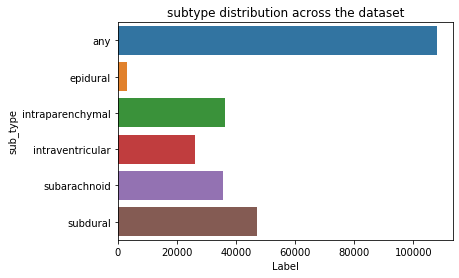

In [42]:
# visualize the subtype distribution
sns.barplot(y = dist_subtype.index, x = dist_subtype.Label)
plt.title('subtype distribution across the dataset')

## Visualize each subtype of each hemorrhage

In [43]:
def window_image(img, window_cntr, window_width, intercept, slope):
    
    img = (img*slope + intercept)
    img_min = window_cntr - window_width//2
    img_max = window_cntr + window_width//2
    img[img<img_min] = img_min
    img[img>img_max] = img_max
    
    return img

In [65]:
def fetch_first_dicom_field(x):
    
    if type(x) == pydicom.multival.MultiValue:
        return int(x[0])
    else:
        return int(x)

In [66]:
def window_info(data):
    dicom_fields = [data[('0028', '1050')].value,
                    data[('0028', '1051')].value,
                    data[('0028', '1052')].value,
                    data[('0028', '1053')].value]
    return [fetch_first_dicom_field(x) for x in dicom_fields]

In [92]:
tmp_table[(tmp_table['sub_type'] == 'subdural') & (tmp_table['Label'] == 1)].head(10)

,ID,Label,sub_type,patient_id
172,ID_85f1fa3bd_subdural,1,subdural,85f1fa3bd
184,ID_4598fa77a_subdural,1,subdural,4598fa77a
208,ID_4c45dcf36_subdural,1,subdural,4c45dcf36
358,ID_8927bc6ee_subdural,1,subdural,8927bc6ee
442,ID_945b3f1e4_subdural,1,subdural,945b3f1e4
514,ID_568242d1d_subdural,1,subdural,568242d1d
736,ID_3e9f3c8d5_subdural,1,subdural,3e9f3c8d5
1012,ID_891e96ff3_subdural,1,subdural,891e96ff3
1108,ID_758c3c2f3_subdural,1,subdural,758c3c2f3
1114,ID_3c300c405_subdural,1,subdural,3c300c405


In [76]:
def show_images(imgs, title = '', aug = None):
    width = 2
    height = 3
    fig, axs = plt.subplots(height, width, figsize = (15, 15))
    
    for i in range(0, height*width):
        
        data = pydicom.read_file(os.path.join(train_images_dir, 'ID_' + imgs[i] + '.dcm'))
        img = data.pixel_array
        
        wind_center, wind_width, intercept, slope = window_info(data)
        img_windowed = window_image(img, wind_center, wind_width, intercept, slope)
        
        x = i // width
        y = i % width
        axs[x, y].imshow(img_windowed, cmap = plt.cm.bone)
        axs[x, y].axis('off')
        
    plt.suptitle(title)
    plt.show()

## Hemorrhage Epidural

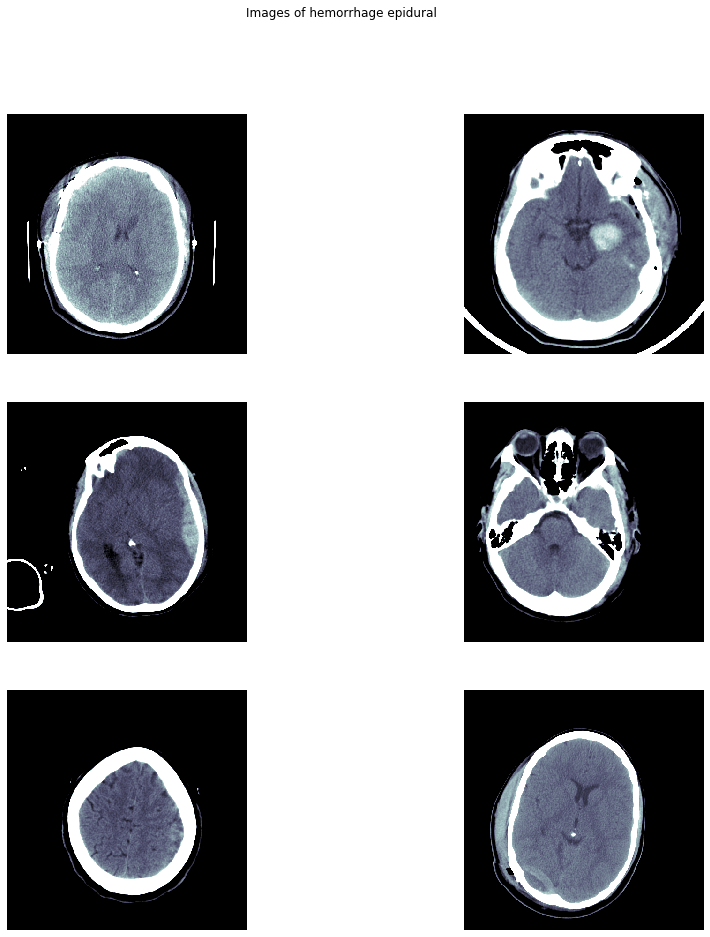

In [83]:
show_images(tmp_table[(tmp_table['sub_type'] == 'epidural') & (tmp_table['Label'] == 1)][:6].patient_id.values, title = 'Images of hemorrhage epidural')

## Intraparenchymal hemorrhage

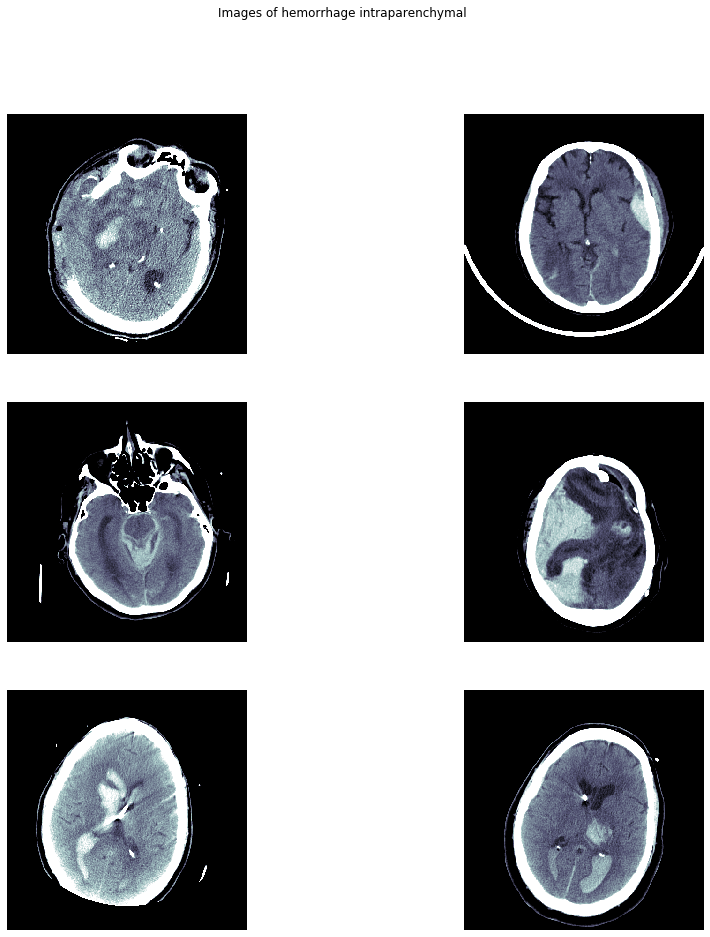

In [88]:
show_images(tmp_table[(tmp_table['sub_type'] == 'intraparenchymal') & (tmp_table['Label'] == 1)][:6].patient_id.values, title = 'Images of hemorrhage intraparenchymal')

## Intraventricular hemorrhage

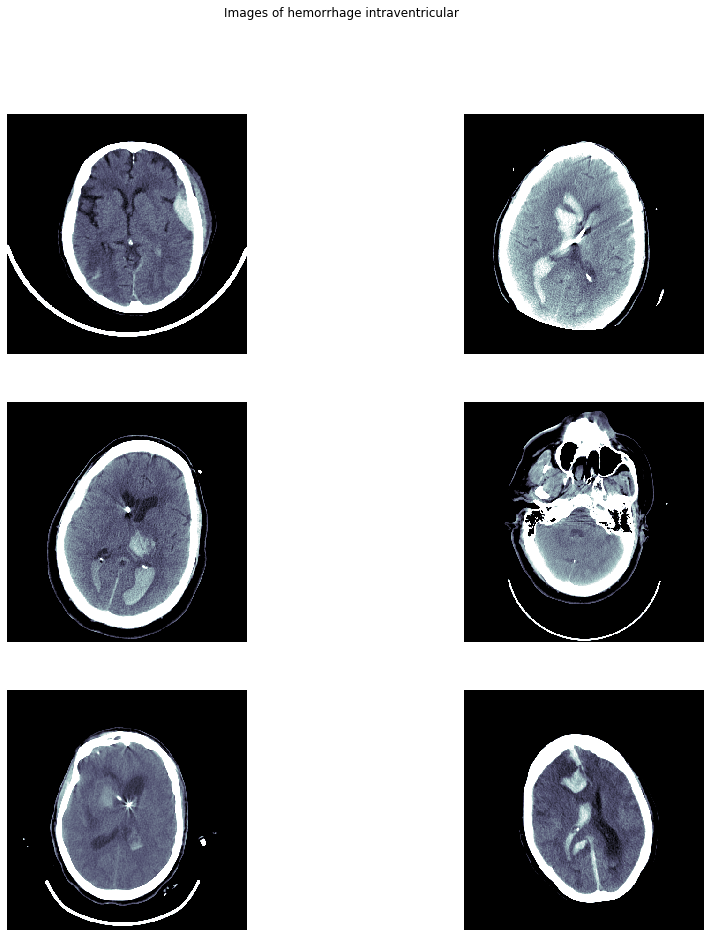

In [89]:
show_images(tmp_table[(tmp_table['sub_type'] == 'intraventricular') & (tmp_table['Label'] == 1)][:6].patient_id.values, title = 'Images of hemorrhage intraventricular')

## Subarachnoid Hemorrhage

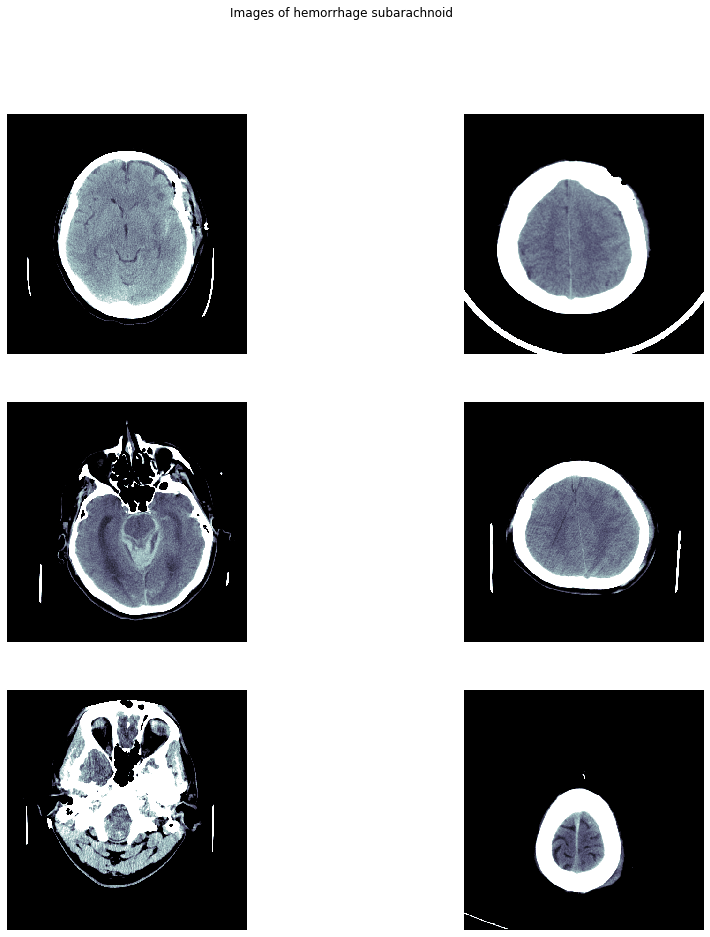

In [93]:
show_images(tmp_table[(tmp_table['sub_type'] == 'subarachnoid') & (tmp_table['Label'] == 1)][:6].patient_id.values, title = 'Images of hemorrhage subarachnoid')

## Subdural Hemorrhage

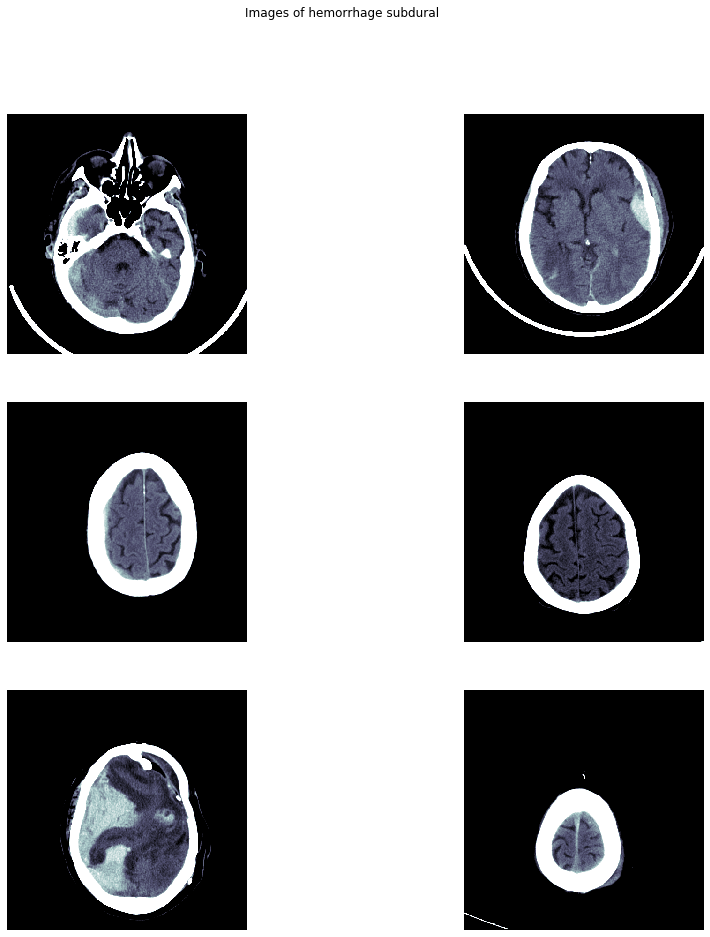

In [95]:
show_images(tmp_table[(tmp_table['sub_type'] == 'subdural') & (tmp_table['Label'] == 1)][:6].patient_id.values, title = 'Images of hemorrhage subdural')